# Whatsapp Chat Analyzer

# Importing all the required Libraries

In [132]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Detecting Date and Time 

In [133]:
def startsWithDateAndTime(s):
    # regex pattern for date.(Works only for android. IOS Whatsapp export format is different. Will update the code soon
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

# Detecting the Author

In [134]:
# Finds username of any given format.
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

# Extracting and Combining 

In [135]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

# Parsing the entire file and handling Multi-Line Messages

In [136]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'WhatsApp Chat with Prayatna HR dept.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDateAndTime(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])

In [137]:
df.head()

,Date,Time,Author,Message
0,2019-06-30,1:36 PM,None,Saara Vashishth Ma'am Pratyn: https://m.facebo...
1,2019-06-30,1:36 PM,None,Saara Vashishth Ma'am Pratyn: We can do someth...
2,2019-06-30,1:43 PM,Chaitanya Praytn,Great idea .!
3,2019-06-30,1:44 PM,Asmit Silhare Clg,Good idea
4,2019-06-30,1:59 PM,Kajal Praytn,Nice..


In [138]:
df.tail()

,Date,Time,Author,Message
4529,2020-09-08,2:07 PM,Khushi Junior Praytn,Example agar 36 log hai toh 12 teams. Toh zaya...
4530,2020-09-08,2:08 PM,Khushi Junior Praytn,And time limit rakh rakh sakte hai 5 min.
4531,2020-09-08,2:09 PM,Ridam Choudhary Praytn,Haa 3 ke place pr 5 person krskte he
4532,2020-09-08,2:14 PM,Khushi Junior Praytn,"Yes, whichever is the most convenient"
4533,2020-09-08,2:16 PM,Ankit,Haan this is good


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534 entries, 0 to 4533
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     4534 non-null   datetime64[ns]
 1   Time     4534 non-null   object        
 2   Author   2540 non-null   object        
 3   Message  4534 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 141.8+ KB


In [140]:
df = df.dropna()

In [141]:
df.Author.unique()

array(['Chaitanya Praytn', 'Asmit Silhare Clg', 'Kajal Praytn',
       'Aayushi Praytn Junior', 'Curiosity', 'Mayank Sir Praytn',
       'Ridam Choudhary Praytn', '+91 81097 27990',
       'Khushi Junior Praytn', '+91 81035 81001', '+91 99777 42786',
       'Vandini Bhatia Clg', '+91 77229 96776', 'Amrik Clg', 'Ankit',
       '+91 78984 60968'], dtype=object)

In [142]:
df.describe()

,Date,Time,Author,Message
count,2540,2540,2540,2540
unique,195,783,16,2052
top,2019-10-09 00:00:00,9:15 PM,Asmit Silhare Clg,<Media omitted>
freq,160,20,809,76
first,2019-06-30 00:00:00,NaN,NaN,NaN
last,2020-09-08 00:00:00,NaN,NaN,NaN


In [143]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [144]:
print('Stats:')
print('Total Messages:-', total_messages)
print('Media Messages:-',media_messages)
print('Emojies:-',emojis)
print('Links:-', links)

Stats:
Total Messages:- 2540
Media Messages:- 76
Emojies:- 1651
Links:- 16


# Number of Letters and Words Per message

In [145]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [146]:
messages_df.head()

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count
2,2019-06-30,1:43 PM,Chaitanya Praytn,Great idea .!,[],0,13,3
3,2019-06-30,1:44 PM,Asmit Silhare Clg,Good idea,[],0,9,2
4,2019-06-30,1:59 PM,Kajal Praytn,Nice..,[],0,6,1
7,2019-06-30,3:24 PM,Aayushi Praytn Junior,😍🔥bahut accha idea han,"[😍, 🔥]",0,22,4
8,2019-06-30,5:08 PM,Curiosity,😍😍,"[😍, 😍]",0,2,1


In [147]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Chaitanya Praytn -
Messages Sent 138
Words per message 9.231884057971014
Media Messages Sent 1
Emojis Sent 146
Links Sent 0

Stats of Asmit Silhare Clg -
Messages Sent 775
Words per message 10.16258064516129
Media Messages Sent 34
Emojis Sent 402
Links Sent 10

Stats of Kajal Praytn -
Messages Sent 117
Words per message 15.572649572649572
Media Messages Sent 5
Emojis Sent 118
Links Sent 0

Stats of Aayushi Praytn Junior -
Messages Sent 268
Words per message 6.126865671641791
Media Messages Sent 9
Emojis Sent 158
Links Sent 0

Stats of Curiosity -
Messages Sent 159
Words per message 6.9937106918239
Media Messages Sent 6
Emojis Sent 79
Links Sent 0

Stats of Mayank Sir Praytn -
Messages Sent 32
Words per message 6.53125
Media Messages Sent 0
Emojis Sent 31
Links Sent 0

Stats of Ridam Choudhary Praytn -
Messages Sent 271
Words per message 10.623616236162361
Media Messages Sent 6
Emojis Sent 286
Links Sent 1

Stats of +91 81097 27990 -
Messages Sent 58
Words per message 6.8275862

# Total number of letters and words count

In [148]:
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(127469, 23853)

# How many words have been sent in total by each author, since the beginning of time

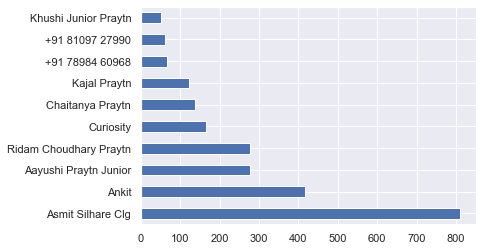

In [149]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
top_10_author_value_counts = author_value_counts.head(10) # Number of messages per author for the top 10 most active authors
top_10_author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis


# Who is more talkative

Text(0, 0.5, 'Authors')

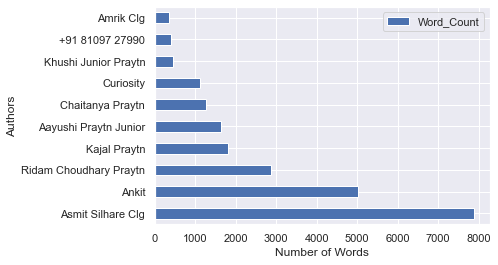

In [150]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

# The most common number of Words in a message

Text(0, 0.5, 'Frequency')

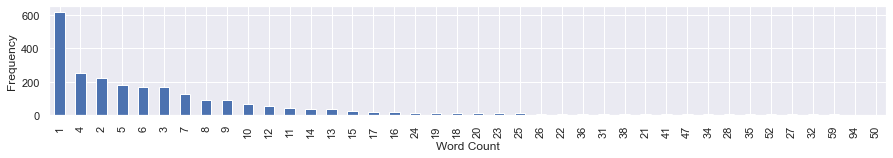

In [151]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# The most common number of letters in a message

Text(0, 0.5, 'Frequency')

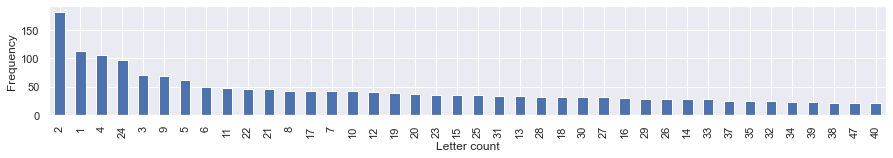

In [152]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

# Most active date

Text(0, 0.5, 'Date')

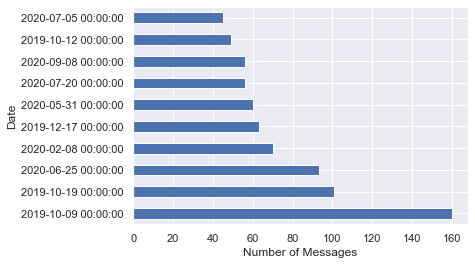

In [153]:
messages_df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

# Time when the chat is most active

Text(0, 0.5, 'Time')

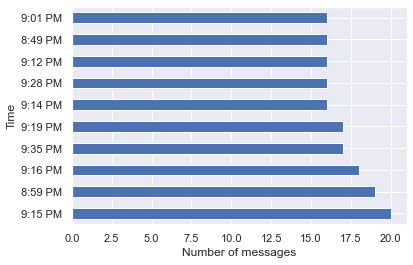

In [154]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

# Hours in between Highest chances of responses

Text(0, 0.5, 'Hour of Day')

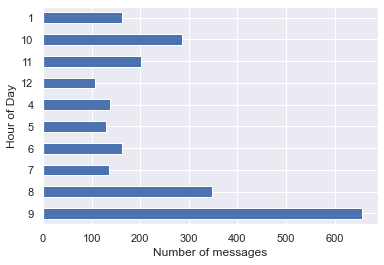

In [155]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) # The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [156]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))


There are 129932 words in all the messages.


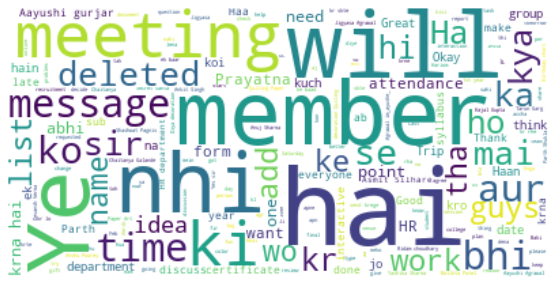

In [157]:
stopwords = set(STOPWORDS)
stopwords.update(["le"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [158]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="Word_Count", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()

# Number of unique emojis used in the group

In [159]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

100


# Most used Emoji in Group

In [160]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

[('😂', 217), ('🔴', 217), ('🔥', 169), ('👍🏻', 146), ('👍', 131), ('🤣', 110), ('🛑', 86), ('💯', 41), ('😅', 37), ('🎅', 29), ('🤩', 27), ('♥️', 26), ('🤟🏻', 23), ('⭕', 20), ('🥁', 19), ('🤘', 17), ('💃', 15), ('🙌', 14), ('🎅🏻', 14), ('🏍', 14), ('💥', 13), ('✨', 12), ('🤭', 10), ('🤝🏻', 9), ('😌', 9), ('😍', 8), ('🤔', 8), ('🙌🏼', 8), ('⏱', 8), ('❤', 7), ('🙋🏻', 7), ('🎅🏼', 7), ('❤️', 7), ('😻', 7), ('🙌🏻', 7), ('👐🏻', 7), ('🙏', 6), ('🤟', 6), ('🥳', 6), ('⚫', 6), ('🎊', 6), ('👎🏻', 5), ('😎', 5), ('🌟', 5), ('🤦🏻\u200d♂️', 5), ('🙏🏻', 4), ('😭', 4), ('👌', 4), ('🎄', 4), ('😁', 4), ('🏍️', 4), ('🤘🏻', 4), ('😊', 3), ('🤚🏻', 3), ('😇', 2), ('👎', 2), ('🙂', 2), ('🤦\u200d♀️', 2), ('😑', 2), ('😡', 2), ('🥴', 2), ('😄', 2), ('✋🏻', 2), ('☺️', 2), ('😕', 2), ('🇮🇳', 2), ('☠️', 2), ('✋', 2), ('🤫', 2), ('😓', 1), ('🥰', 1), ('☹', 1), ('😈', 1), ('🙃', 1), ('❣', 1), ('🤪', 1), ('😪', 1), ('☝️', 1), ('😏', 1), ('🎅🏽', 1), ('💞', 1), ('⌛', 1), ('✌️', 1), ('😒', 1), ('🙄', 1), ('😬', 1), ('🙋🏻\u200d♀️', 1), ('🙋🏻\u200d♂️', 1), ('🥺', 1), ('🤦\u200d♂️', 1), ('😆'

,emoji,count
0,😂,217
1,🔴,217
2,🔥,169
3,👍🏻,146
4,👍,131
...,...,...
95,😃,1
96,😣,1
97,😷,1
98,✌🏻,1


In [161]:
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [162]:
def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,6000]
    )),
  showlegend=False
)
fig.show()

We can see that Wednesday and Tuesday has the most number of messages(something more than 6000).